# Drug Traffiking experiment: improved model

This notebooks contains the data processing, building and training part of the model used for the enhanced iteration of the drug traffiking experiment. 

In [1]:
import shap
import random
import numpy as np
import pandas as pd
from keras import layers
from tensorflow import keras
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.utils import class_weight
from sklearn.preprocessing import MinMaxScaler
from aif360.datasets import BinaryLabelDataset
from aif360.metrics import BinaryLabelDatasetMetric
from sklearn.model_selection import train_test_split
from aif360.algorithms.preprocessing import Reweighing
from fairlearn.postprocessing import ThresholdOptimizer
from sklearn.metrics import classification_report,confusion_matrix
from witwidget.notebook.visualization import WitWidget, WitConfigBuilder

pip install 'aif360[inFairness]'


## Functions and Utils

In [2]:
def minmax_scaler(data):
  scaler = MinMaxScaler()
  scaled = scaler.fit_transform(data)
  return scaled

def process_data(data):
  x = data.loc[:, data.columns != 'Tipo salida 2']
  y = data['Tipo salida 2']

  x_cat = x[['Region', 'Defensor', 'Desarrollo','extranjero']]
  x_cat['Region'] = label_encoder.fit_transform(x_cat['Region'])
  x_cat['Defensor'] = label_encoder.fit_transform(x_cat['Defensor'])
  x_cat['Desarrollo'] = label_encoder.fit_transform(x_cat['Desarrollo'])
  x_cat['extranjero'] = label_encoder.fit_transform(x_cat['extranjero'])

  x_num = x.loc[:, ~x.columns.isin(x_cat.columns)]

  x_norm = minmax_scaler(x_num)
  x_norm = pd.DataFrame(x_norm, columns = x_num.columns)

  x_norm.reset_index(drop=True, inplace=True)
  x_cat.reset_index(drop=True, inplace=True)

  x_fin = pd.concat([x_norm, x_cat], axis = 1)
  #y_fin = label_encoder.fit_transform(y)

  return x_fin

def custom_predict(examples_to_infer):

  preds = model1.predict(model_inputs)
  preds = [[1 - pred[0], pred[0]] for pred in preds]
  return preds

## Importing data and pre-processing

In [3]:
path = r'traficoDrogas.csv'
data = pd.read_csv(path)

## Cambiando las dos RM a una sola

data['Región (tribunal)']=data['Región (tribunal)'].replace('Metropolitana Sur','Metropolitana')
data['Región (tribunal)']=data['Región (tribunal)'].replace('Metropolitana Norte','Metropolitana')

## Sacar filas erróneas

data.drop(16690, inplace=True)
data.drop(16691, inplace=True)

In [4]:
## Agregar variable edad: se prueban con distribución normal y uniforme (estudio drogas SENDA 2020)

data['age_normal'] = np.nan

mu = 27 ## Edad promedio entre 18 y 34 años (concentran la mayoría de consumo de drogas)
sigma = 8
random.seed(23)

for i in range(len(data)):
    data['age_normal'][i] = round(max(18, min(np.random.normal(mu, sigma), 65)))

## Agregar variable extranjero

data['foreigner'] = np.nan

for i in range(len(data)):
    if data['P.S. Expulsión'][i] == 'N':
        data['foreigner'][i] = 'no'
    else:
        data['foreigner'][i] = 'yes'

/var/folders/dv/yyl2yv_j3hl4xyrt3r2qmh4h0000gn/T/ipykernel_90891/2269476441.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['age_normal'][i] = round(max(18, min(np.random.normal(mu, sigma), 65)))
/var/folders/dv/yyl2yv_j3hl4xyrt3r2qmh4h0000gn/T/ipykernel_90891/2269476441.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['age_normal'][i] = round(max(18, min(np.random.normal(mu, sigma), 65)))
/var/folders/dv/yyl2yv_j3hl4xyrt3r2qmh4h0000gn/T/ipykernel_90891/2269476441.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: h

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16690 entries, 0 to 16689
Data columns (total 26 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Región (tribunal)       16690 non-null  object 
 1   Defensor                16690 non-null  object 
 2   Imputado                16690 non-null  object 
 3   CAUSAIMPUTADOID         16690 non-null  float64
 4   RUD                     16690 non-null  object 
 5   Fecha término           16690 non-null  object 
 6   Audiencias efectivas    16690 non-null  float64
 7   Delito                  16690 non-null  object 
 8   Grado desarrollo        16690 non-null  object 
 9   Forma término           16690 non-null  object 
 10  Forma término SIGDP     16690 non-null  object 
 11  Pena solicitada por MP  9285 non-null   object 
 12  Tramo ID MP             9038 non-null   float64
 13  Años MP                 8915 non-null   float64
 14  Días MP                 3659 non-null   flo

In [6]:
data.drop(data.columns[[2, 3, 4, 5, 7, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]], axis=1, inplace=True)
data.rename(columns = {'Región (tribunal)':'region', 
                       'Grado desarrollo':'crime_stage',
                       'Defensor': 'barrister',
                       'Audiencias efectivas': 'effective_hearings'}, inplace = True)

## Data Transformations

In [7]:
x1 = data.loc[:, ~data.columns.isin(['Tipo salida 1', 'Tipo salida 2'])]
y1 = data.loc[:, data.columns.isin(['Tipo salida 1', 'Tipo salida 2'])]

In [8]:
x_train1, x_test1, y_train1, y_test1 = train_test_split(x1, y1['Tipo salida 2'], test_size=0.3, random_state = 23)

## Del set de entrenamiento, se desprenden 1000 datos para generar un dataset de validación

x_val1 = x_train1[-1000:]
y_val1 = y_train1[-1000:]

In [9]:
x_cat_train = x_train1[['region', 'barrister', 'crime_stage','foreigner']]
x_cat_test = x_test1[['region', 'barrister', 'crime_stage','foreigner']]
x_cat_val = x_val1[['region', 'barrister', 'crime_stage','foreigner']]

In [10]:
label_encoder = preprocessing.LabelEncoder()

x_cat_train['barrister'] = label_encoder.fit_transform(x_cat_train['barrister'])
x_cat_train['crime_stage'] = label_encoder.fit_transform(x_cat_train['crime_stage'])
x_cat_train['foreigner'] = label_encoder.fit_transform(x_cat_train['foreigner'])
x_cat_train['region'] = label_encoder.fit_transform(x_cat_train['region'])

x_cat_test['barrister'] = label_encoder.fit_transform(x_cat_test['barrister'])
x_cat_test['crime_stage'] = label_encoder.fit_transform(x_cat_test['crime_stage'])
x_cat_test['foreigner'] = label_encoder.fit_transform(x_cat_test['foreigner'])
x_cat_test['region'] = label_encoder.fit_transform(x_cat_test['region'])

x_cat_val['barrister'] = label_encoder.fit_transform(x_cat_val['barrister'])
x_cat_val['crime_stage'] = label_encoder.fit_transform(x_cat_val['crime_stage'])
x_cat_val['foreigner'] = label_encoder.fit_transform(x_cat_val['foreigner'])
x_cat_val['region'] = label_encoder.fit_transform(x_cat_val['region'])

/var/folders/dv/yyl2yv_j3hl4xyrt3r2qmh4h0000gn/T/ipykernel_90891/1070950659.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_cat_train['barrister'] = label_encoder.fit_transform(x_cat_train['barrister'])
/var/folders/dv/yyl2yv_j3hl4xyrt3r2qmh4h0000gn/T/ipykernel_90891/1070950659.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_cat_train['crime_stage'] = label_encoder.fit_transform(x_cat_train['crime_stage'])
/var/folders/dv/yyl2yv_j3hl4xyrt3r2qmh4h0000gn/T/ipykernel_90891/1070950659.py:5: SettingW

In [11]:
x_num_train = x_train1.loc[:, ~x_train1.columns.isin(x_cat_train.columns)]
x_num_test = x_test1.loc[:, ~x_test1.columns.isin(x_cat_test.columns)]
x_num_val = x_val1.loc[:, ~x_val1.columns.isin(x_cat_val.columns)]

In [12]:
x_norm_train = minmax_scaler(x_num_train)
x_norm_train = pd.DataFrame(x_norm_train, columns = x_num_train.columns)

x_norm_test = minmax_scaler(x_num_test)
x_norm_test = pd.DataFrame(x_norm_test, columns = x_num_test.columns)

x_norm_val = minmax_scaler(x_num_val)
x_norm_val = pd.DataFrame(x_norm_val, columns = x_num_val.columns)

In [13]:
for x in range(len(label_encoder.classes_)):
  print(x, label_encoder.classes_[x])

0 Antofagasta
1 Arica y Parinacota
2 Atacama
3 Aysén
4 Bio Bío
5 Coquimbo
6 La Araucanía
7 Libertador Bernardo O'Higgins
8 Los Lagos
9 Los Ríos
10 Magallanes y Antártica Chilena
11 Maule
12 Metropolitana
13 Tarapacá
14 Valparaíso
15 Ñuble


In [14]:
x_cat_train['region_alt'] = x_cat_train['region'].apply(lambda x: 1 if x in {13, 5, 0, 1, 2, 11, 15, 4} else 0)
x_cat_test['region_alt'] = x_cat_test['region'].apply(lambda x: 1 if x in {13, 5, 0, 1, 2, 11, 15, 4} else 0)
x_cat_val['region_alt'] = x_cat_val['region'].apply(lambda x: 1 if x in {13, 5, 0, 1, 2, 11, 15, 4} else 0)

/var/folders/dv/yyl2yv_j3hl4xyrt3r2qmh4h0000gn/T/ipykernel_90891/1960024256.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_cat_train['region_alt'] = x_cat_train['region'].apply(lambda x: 1 if x in {13, 5, 0, 1, 2, 11, 15, 4} else 0)
/var/folders/dv/yyl2yv_j3hl4xyrt3r2qmh4h0000gn/T/ipykernel_90891/1960024256.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_cat_test['region_alt'] = x_cat_test['region'].apply(lambda x: 1 if x in {13, 5, 0, 1, 2, 11, 15, 4} else 0)
/var/folders/dv/yyl2yv_j3hl4xyrt3r

In [15]:
x_norm_train.reset_index(drop=True, inplace=True)
x_cat_train.reset_index(drop=True, inplace=True)

x_norm_test.reset_index(drop=True, inplace=True)
x_cat_test.reset_index(drop=True, inplace=True)

x_norm_val.reset_index(drop=True, inplace=True)
x_cat_val.reset_index(drop=True, inplace=True)

In [16]:
x_train_fin = pd.concat([x_norm_train, x_cat_train], axis = 1)
x_test_fin = pd.concat([x_norm_test, x_cat_test], axis = 1)
x_val_fin = pd.concat([x_norm_val, x_cat_val], axis = 1)

y_train_fin = label_encoder.fit_transform(y_train1)
y_test_fin = label_encoder.fit_transform(y_test1)
y_val_fin = label_encoder.fit_transform(y_val1)

## Using AIF360

In [17]:
dataset_train = BinaryLabelDataset(
    df = pd.concat([x_train_fin,pd.DataFrame(y_train_fin, columns = ['Tipo salida 2'])], axis = 1),
    label_names = ['Tipo salida 2'],
    protected_attribute_names = ['region_alt'], #['Extranjero'],
    favorable_label = 1,
    unfavorable_label = 0
)

privileged_groups = [{'region_alt': 1}] 
unprivileged_groups = [{'region_alt': 0}]

In [18]:
metric_orig_train = BinaryLabelDatasetMetric(dataset_train,
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)


# Métrica de equidad (mean difference)
metric_f = metric_orig_train.mean_difference()
print("Diferencia en los resultados medios entre grupos privilegiados y no privilegiados = %f" % metric_f)

Diferencia en los resultados medios entre grupos privilegiados y no privilegiados = -0.278263


In [19]:
RW = Reweighing(unprivileged_groups=unprivileged_groups,
                privileged_groups=privileged_groups)

dataset_transf_train = RW.fit_transform(dataset_train)

In [20]:
metric_orig_train = BinaryLabelDatasetMetric(dataset_transf_train,
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)

# Métrica de equidad (mean difference)
metric_f_2 = metric_orig_train.mean_difference()

print("Diferencia en los resultados medios entre grupos privilegiados y no privilegiados = %f" % metric_f_2)

Diferencia en los resultados medios entre grupos privilegiados y no privilegiados = -0.000000


In [21]:
x_train_fin.drop(columns = ['region_alt'], inplace = True)
x_test_fin.drop(columns = ['region_alt'], inplace = True)
x_val_fin.drop(columns = ['region_alt'], inplace = True)

In [22]:
train_fin =  pd.concat([x_train_fin, pd.DataFrame(y_train_fin, columns = ['Tipo salida 2'])], axis = 1)
train_fin

effective_hearings  age_normal  region  barrister  crime_stage  \
0                0.094595    0.000000      13         39            0   
1                0.067568    0.000000      12        530            0   
2                0.040541    0.179487      13        116            0   
3                0.081081    0.000000       1        850            0   
4                0.013514    0.230769      12        369            0   
...                   ...         ...     ...        ...          ...   
11678            0.121622    0.282051       1        124            0   
11679            0.054054    0.076923      13        479            0   
11680            0.067568    0.000000       0        292            0   
11681            0.121622    0.102564      15        308            0   
11682            0.067568    0.538462      11        185            0   

       foreigner  Tipo salida 2  
0              1              1  
1              0              0  
2              1              1  
3              0              0  
4              0              1  
...          ...            ...  
11678          0              0  
11679          1              1  
11680          0              0  
11681          0              0  
11682          0              1  

[11683 rows x 7 columns]

## Building the model

In [23]:
num_classes1 = 1
num_features1 = x_train_fin.shape[1]
num_output1 = 1

num_layers_01 = 14
num_layers_11 = 12

epochs1 = 70
learning_rate1 = 0.01
batch_size1 = 1024

In [24]:
inputs1 = keras.Input(shape = (num_features1,), name = "data")

x11 = layers.Dense(num_layers_01, activation = "relu", name = "dense_1")(inputs1)
x21 = layers.Dense(num_layers_11, activation = "relu", name = "dense_2")(x11)

outputs1 = layers.Dense(num_output1, activation = "sigmoid", name = "predictions")(x21)

model1 = keras.Model(inputs = inputs1, outputs = outputs1)

In [25]:
class_weights = class_weight.compute_class_weight(class_weight = 'balanced', classes = np.unique(y_train_fin), y = y_train_fin)
class_weights = dict(enumerate(class_weights))

sample_weight = dataset_transf_train.instance_weights

## Training and metrics

In [26]:
## Compilando el modelo

model1.compile(
    optimizer = keras.optimizers.Adam(learning_rate = learning_rate1),
    loss = keras.losses.BinaryCrossentropy(from_logits = False),
    metrics = [keras.metrics.Precision(name='precision_05', thresholds=0.5),
               keras.metrics.Precision(name='precision_025', thresholds=0.25),
               keras.metrics.Recall(name='recall_05', thresholds=0.5),
               keras.metrics.Recall(name='recall_025', thresholds=0.25),
               keras.metrics.FalseNegatives(name='fn_05', thresholds=0.5),
               keras.metrics.FalseNegatives(name='fn_025', thresholds=0.25),
               keras.metrics.BinaryAccuracy(name='accuracy_05', threshold=0.5),
               keras.metrics.BinaryAccuracy(name='accuracy_025', threshold=0.25)],
)

In [27]:
# Entrenando el modelo

training1 = model1.fit(
    x_train_fin,
    y_train_fin,
    batch_size = batch_size1,
    epochs = epochs1,
    class_weight = class_weights,
    #sample_weight = sample_weight,
    validation_data = (x_val_fin, y_val_fin)
)

Epoch 1/70
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy_025: 0.5168 - accuracy_05: 0.5141 - fn_025: 1275.0769 - fn_05: 1337.5385 - loss: 31.8247 - precision_025: 0.5340 - precision_05: 0.5322 - recall_025: 0.7654 - recall_05: 0.7536 - val_accuracy_025: 0.5460 - val_accuracy_05: 0.5400 - val_fn_025: 103.0000 - val_fn_05: 228.0000 - val_loss: 0.8044 - val_precision_025: 0.5602 - val_precision_05: 0.5812 - val_recall_025: 0.8127 - val_recall_05: 0.5855
Epoch 2/70
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy_025: 0.5280 - accuracy_05: 0.5246 - fn_025: 720.0000 - fn_05: 872.7692 - loss: 4.0633 - precision_025: 0.5426 - precision_05: 0.5445 - recall_025: 0.7945 - recall_05: 0.7463 - val_accuracy_025: 0.5100 - val_accuracy_05: 0.4640 - val_fn_025: 364.0000 - val_fn_05: 536.0000 - val_loss: 1.7234 - val_precision_025: 0.5962 - val_precision_05: 1.0000 - val_recall_025: 0.3382 - val_recall_05: 0.0255
Epoch 3/70
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy_025: 0.5227 - accuracy_

## Model Evaluation

In [28]:
## Generando predicciones

predict_train1 = (model1.predict(x_train_fin) > 0.5).astype(int)
predict_test1 = (model1.predict(x_test_fin) > 0.5).astype(int)

366/366 ━━━━━━━━━━━━━━━━━━━━ 0s 271us/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 224us/step


In [29]:
## Matriz de confusión para dataset de entrenamiento 1

print(confusion_matrix(y_train_fin,predict_train1))
print(classification_report(y_train_fin,predict_train1))

[[5421    2]
 [2376 3884]]
              precision    recall  f1-score   support

           0       0.70      1.00      0.82      5423
           1       1.00      0.62      0.77      6260

    accuracy                           0.80     11683
   macro avg       0.85      0.81      0.79     11683
weighted avg       0.86      0.80      0.79     11683



In [30]:
## Matriz de confusión para dataset de prueba 1

print(confusion_matrix(y_test_fin,predict_test1))
print(classification_report(y_test_fin,predict_test1))

[[2324    2]
 [1088 1593]]
              precision    recall  f1-score   support

           0       0.68      1.00      0.81      2326
           1       1.00      0.59      0.75      2681

    accuracy                           0.78      5007
   macro avg       0.84      0.80      0.78      5007
weighted avg       0.85      0.78      0.78      5007



## Using Fairlearn

In [31]:
postprocess_est = ThresholdOptimizer(
    estimator=model1,
    constraints="false_negative_rate_parity",  # Optimize FPR and FNR simultaneously
    objective="accuracy_score",
    prefit=True,
    predict_method="predict",
)

In [32]:
postprocess_est.fit(x_train_fin, y_train_fin, sensitive_features = x_train_fin['region'])

366/366 ━━━━━━━━━━━━━━━━━━━━ 0s 238us/step


/opt/anaconda3/lib/python3.11/site-packages/fairlearn/postprocessing/_threshold_optimizer.py:325: UserWarning: The value of `prefit` is `True`, but `check_is_fitted` raised `NotFittedError` on the base estimator.

If the provided base estimator has been fitted, this could mean that (1) its implementation does not conform to the sklearn estimator API, or (2) the enclosing ThresholdOptimizer has been cloned (for instance by `sklearn.model_selection.cross_validate`).

In case (1), please file an issue with the base estimator developers, but continue to use the enclosing ThresholdOptimizer with `prefit=True`. In case (2), please use `prefit=False`.
  warn(BASE_ESTIMATOR_NOT_FITTED_WARNING.format(type(self).__name__))
/opt/anaconda3/lib/python3.11/site-packages/fairlearn/postprocessing/_interpolated_thresholder.py:119: UserWarning: The value of `prefit` is `True`, but `check_is_fitted` raised `NotFittedError` on the base estimator.

If the provided base estimator has been fitted, this could

ThresholdOptimizer(constraints='false_negative_rate_parity',
                   estimator=<Functional name=functional, built=True>,
                   predict_method='predict', prefit=True)

In [33]:
predict_train2 = postprocess_est.predict(x_train_fin, sensitive_features = x_train_fin['region'])
predict_test2 = postprocess_est.predict(x_test_fin, sensitive_features = x_test_fin['region'])

366/366 ━━━━━━━━━━━━━━━━━━━━ 0s 225us/step
  1/157 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step

/opt/anaconda3/lib/python3.11/site-packages/fairlearn/postprocessing/_interpolated_thresholder.py:166: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0. 0. 0. ... 0. 0. 0.]' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  positive_probs[sensitive_feature_vector == a] = interpolated_predictions[


157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 239us/step


/opt/anaconda3/lib/python3.11/site-packages/fairlearn/postprocessing/_interpolated_thresholder.py:166: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.         0.         0.         0.98351477 0.98351477 0.98351477
 0.98351477 0.         1.         0.98351477 0.         0.98351477
 0.98351477 0.         0.98351477 0.         0.98351477 0.98351477
 0.         0.98351477 0.98351477 0.         0.98351477 1.
 0.98351477 0.         0.         0.         0.98351477 0.98351477
 0.         0.         0.98351477 0.         0.98351477 0.98351477
 0.         0.         0.98351477 0.98351477 0.98351477 0.
 0.         0.98351477 0.         0.98351477 0.98351477 0.
 0.         0.         0.         0.         0.98351477 0.
 0.         0.         0.         0.         0.98351477 0.98351477
 0.         0.98351477 0.98351477 0.         0.98351477 0.98351477
 0.98351477 0.         0.         0.98351477 0.         0.
 0.98351477 0. 

In [34]:
## Matriz de confusión para dataset de entrenamiento 2

print(confusion_matrix(y_train_fin,predict_train2))
print(classification_report(y_train_fin,predict_train2))

[[3276 2147]
 [1712 4548]]
              precision    recall  f1-score   support

           0       0.66      0.60      0.63      5423
           1       0.68      0.73      0.70      6260

    accuracy                           0.67     11683
   macro avg       0.67      0.67      0.67     11683
weighted avg       0.67      0.67      0.67     11683



In [35]:
## Matriz de confusión para dataset de prueba 2

print(confusion_matrix(y_test_fin,predict_test2))
print(classification_report(y_test_fin,predict_test2))

[[1238 1088]
 [ 684 1997]]
              precision    recall  f1-score   support

           0       0.64      0.53      0.58      2326
           1       0.65      0.74      0.69      2681

    accuracy                           0.65      5007
   macro avg       0.65      0.64      0.64      5007
weighted avg       0.65      0.65      0.64      5007



## Saving results and model

In [36]:
test_results = pd.DataFrame(predict_test1, columns=['score'])

x_test1_alt = x_test1.reset_index(drop=True)
y_test1_alt = y_test1.reset_index(drop=True)

test = pd.concat([x_test1_alt, test_results, pd.DataFrame(y_test_fin)], axis = 1)

path2 = r'outputs/preds_dt_improved.csv'
test.to_csv(path2)

In [37]:
model1.save('outputs/dt_improved.keras')

## SHAP Values

In [38]:
explainer = shap.Explainer(model1, x_train_fin.values[:])
shap_values = explainer(x_train_fin.values[:])
shap_values

ExactExplainer explainer: 11684it [00:25, 288.49it/s]                           


.values =
array([[ 2.96627765e-04,  8.65708252e-04,  1.48478408e-02,
         1.32321904e-02,  0.00000000e+00,  4.69044912e-01],
       [-4.98317393e-04,  5.32295033e-04,  1.69112309e-03,
        -1.02750470e-02,  0.00000000e+00, -2.89525309e-01],
       [-7.87743524e-04,  6.84649547e-05,  4.31391518e-03,
         2.26610068e-02,  0.00000000e+00,  4.74352998e-01],
       ...,
       [-5.34593530e-04,  5.14694000e-04, -6.01473928e-03,
         2.53203602e-02,  0.00000000e+00, -2.82750586e-01],
       [ 2.07310299e-03,  3.62469743e-04,  3.51629457e-03,
         2.27287386e-02,  0.00000000e+00, -2.81831736e-01],
       [-5.54435966e-04, -7.09368877e-04,  1.27348478e-03,
         4.26405257e-02,  0.00000000e+00, -2.78794819e-01]])

.base_values =
array([[0.49119179],
       [0.49119179],
       [0.49119179],
       ...,
       [0.49119179],
       [0.49119179],
       [0.49119179]])

.data =
array([[9.45945946e-02, 0.00000000e+00, 1.30000000e+01, 3.90000000e+01,
        0.00000000e+00, 1.0

In [39]:
shap_values.feature_names = list(x_train_fin.columns)

In [40]:
shap_df = pd.DataFrame(shap_values.values, columns=shap_values.feature_names)

# Calcular el valor absoluto y luego el promedio para cada característica
shap_abs_avg = shap_df.abs().mean()
shap_avg = shap_df.mean()
shap_max = shap_df.max()
shap_min= shap_df.min()

print('Media absoluta: ', '\n\n', shap_abs_avg)
print('----------------------------------')
print('Media: ', '\n\n', shap_avg)
print('----------------------------------')
print('Máximo: ', '\n\n', shap_max)
print('----------------------------------')
print('Mínimo: ', '\n\n', shap_min)

Media absoluta:  

 effective_hearings    0.001543
age_normal            0.000378
region                0.003375
barrister             0.026019
crime_stage           0.000150
foreigner             0.354182
dtype: float64
----------------------------------
Media:  

 effective_hearings    0.000168
age_normal           -0.000019
region               -0.000265
barrister             0.001651
crime_stage           0.000150
foreigner            -0.028071
dtype: float64
----------------------------------
Máximo:  

 effective_hearings    0.049098
age_normal            0.012036
region                0.022573
barrister             0.223042
crime_stage           0.399240
foreigner             0.514389
dtype: float64
----------------------------------
Mínimo:  

 effective_hearings   -0.004016
age_normal           -0.013068
region               -0.062707
barrister            -0.075456
crime_stage           0.000000
foreigner            -0.299254
dtype: float64


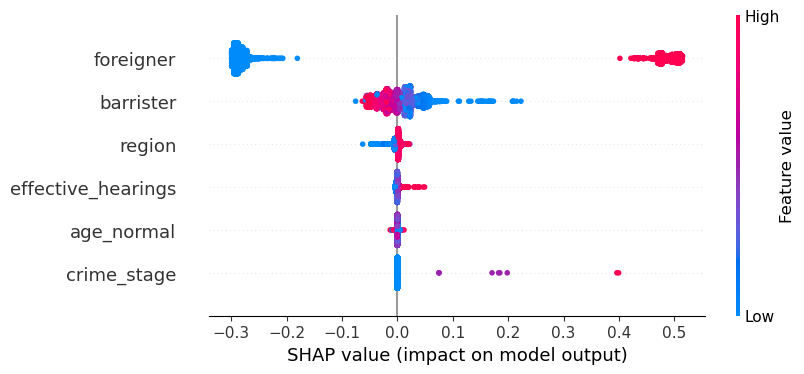

In [41]:
fig, ax = plt.subplots()
shap.plots.beeswarm(shap_values)

In [42]:
fig.savefig("outputs/dt_improved_normal_shap.pdf", bbox_inches="tight", format="pdf")  # o "shap_plot.svg" para formato SVG

## What if Tool

In [43]:
num_datapoints = 5007
tool_height_in_px = 750

examples_labels = pd.concat([x_test_fin.reset_index(drop=True), pd.DataFrame(y_test_fin, columns = ['Tipo salida 2']).reset_index(drop=True)], axis=1)
columns_not_for_model_input = [examples_labels.columns.get_loc('Tipo salida 2')]

examples_wit = examples_labels.values.tolist()
column_names = examples_labels.columns.tolist()

model_inputs = np.delete(np.array(examples_wit[:num_datapoints]), columns_not_for_model_input, axis=1)

def custom_predict_shap(examples_to_infer):

  preds = model1.predict(model_inputs)
  preds = [[1 - pred[0], pred[0]] for pred in preds]

  shap_output = explainer(model_inputs)
  attributions = []
  for single_shap_output in shap_output:  # iteramos sobre cada resultado de shap (cada ejemplo)
    attrs = {}
    for i, col in enumerate(x_train_fin.columns):
      attrs[col] = single_shap_output.values[i]  # utilizamos single_shap_output.values
    attributions.append(attrs)

  ret = {'predictions': preds, 'attributions': attributions}

  return ret

In [44]:
# Setup the tool with the test examples and the trained classifier

config_builder = WitConfigBuilder(examples_wit[:num_datapoints],column_names).set_custom_predict_fn(custom_predict_shap).set_target_feature('Tipo salida 2')
WitWidget(config_builder, height=tool_height_in_px)

WitWidget(config={'model_type': 'classification', 'label_vocab': [], 'feature_names': ['effective_hearings', '…